## Code for the Analysis

In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, f1_score, roc_auc_score,\
                recall_score
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
#from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from sklearn import metrics
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import recall_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge 
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


### Reading and Writing the drug consumption data 

In [4]:
names = ['id','age', "gender", "education", "country","ethnicity","neuroticism", "extraversion", 
"openness", "agreeableness", "conscient", "impulsuv","SS", "alco_consp", "amphet_consp", "amly_consp",
"benzos_consp", "caff_consp", "cannabis_consp","choc_consp", "cocaine_consp", "crack_consp",
"ecstasy_consp", "heroin_consp", "ketamine_consp","legalh_consp", "lsd_consp", "meth_consp", 
"mmushroom_consp","nicotine_consp", "semeron_consp", "vsa_consp"]

# reading drug consumption data
drug_consumption = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data",
                               header = None,index_col = None, names = names)
# writing data
drug_consumption.to_csv("../data/drug_consumption.csv")
drug_consumption.head()

# some data wrangling
# coding drug consumption variables into binary consumption variable based on frequecy of use
drug_data = drug_consumption.copy()
for i in names:
    if drug_data[i].dtype == 'object':
        #drug_data[i + "_ever"] = drug_data[i].map({"CL0": 0, "CL1": 1, "CL2": 1, "CL3": 1, 
        #                                "CL4": 1, "CL5":1, "CL6":1})
        drug_data[i + "_decade"] = drug_data[i].map({"CL0": 0, "CL1": 0, "CL2": 1, "CL3": 1, 
                                        "CL4": 1, "CL5":1, "CL6":1})
        #drug_data[i + "_year"] = drug_data[i].map({"CL0": 0, "CL1": 0, "CL2": 0, "CL3": 1, 
        #                                "CL4": 1, "CL5":1, "CL6":1})
        #drug_data[i + "_month"] = drug_data[i].map({"CL0": 0, "CL1": 0, "CL2": 0, "CL3": 0, 
        #                                "CL4": 1, "CL5":1, "CL6":1})
        #drug_data[i + "_week"] = drug_data[i].map({"CL0": 0, "CL1": 0, "CL2": 0, "CL3": 0, 
        #                                "CL4": 0, "CL5":1, "CL6":1})
        #drug_data[i + "_day"] = drug_data[i].map({"CL0": 0, "CL1": 0, "CL2": 0, "CL3": 0, 
        #                                "CL4": 0, "CL5":0, "CL6":1})
        drug_data.drop([i], axis =1, inplace = True)

# coding gender variable into categorical variable: female == 1, male == 0
drug_data["gender"] = np.where(drug_data['gender']>0, 1, 0) 
drug_data.drop('id', axis =1, inplace = True)
print(drug_data.shape)
#print(drug_data.columns)
drug_data.head()


(1885, 31)


,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscient,...,ecstasy_consp_decade,heroin_consp_decade,ketamine_consp_decade,legalh_consp_decade,lsd_consp_decade,meth_consp_decade,mmushroom_consp_decade,nicotine_consp_decade,semeron_consp_decade,vsa_consp_decade
0,0.49788,1,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,1,0,0
1,-0.07854,0,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,1,0,1,0,1,1,0,1,0,0
2,0.49788,0,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,0,0,0
3,-0.95197,1,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,1,0,0,0,0,1,0,0
4,0.49788,1,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,1,1,0,0


Drug consumptions were encoded into seven categories "Never used", "Used over a Decade Ago", "Used in Last Decade", "Used in Last Year", "Used in Last Month", "Used in Last Week", "Used in Last Day". I binarized the seven categories into "used/using" and "not used". 

Given the high number of drugs (18 drugs), I have decided to study three drug consumptions, namely LSD, crack and amyl nitrite.
 
First, I will run machine learning models only using personal traits to predict `lsd_consumption`, `crack_consumption` and `amly_consumption`. Then I will include drug consumption informations in the data as using targeted drug consumption as dependent (target) variable.

In [5]:
# creating personal traits data
drug_traits = drug_data.loc[:,['age', "gender", "education", "country", "ethnicity","neuroticism", 
        "extraversion", "openness", "agreeableness", "conscient", "impulsuv","SS"]]

print(drug_traits.shape)
drug_traits.head()

(1885, 12)


,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscient,impulsuv,SS
0,0.49788,1,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084
1,-0.07854,0,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
2,0.49788,0,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
3,-0.95197,1,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
4,0.49788,1,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575


## Exploratory Data Analysis

>Some of the exploratory data analyses were performed here.

In [179]:
# coding categorical variables for vizualization

statistical_data = drug_data.copy()
statistical_data['age'] = statistical_data['age'].astype('category').cat.\
        rename_categories(["18-24", "25-34", "35-44", "45-54", "55-64", "65+"])
    
statistical_data['gender'] = statistical_data['gender'].astype('category').cat.\
        rename_categories(["Male", "Female"])    
    
statistical_data['education'] = statistical_data['education'].astype('category').cat.\
        rename_categories(["left < 16", "left = 16", "left = 17", "left = 18", "no degree",
                          "certificate", "university", "master", "doctorate"])
    
statistical_data['country'] = statistical_data['country'].astype('category').cat.\
        rename_categories(["Australia", "Canada", "New Zealand", "Other", "Ireland","UK", "USA"])

statistical_data['ethnicity'] = statistical_data['ethnicity'].astype('category').cat.\
        rename_categories(["Asian", "Black", "Mixed-B/A", "Mixed-W/A", "Mixed-W/B","Other", "White"])

statistical_data['lsd_consp_decade'] = statistical_data['lsd_consp_decade'].astype("category").cat.\
        rename_categories(["not used", "used/using"])

statistical_data['crack_consp_decade'] = statistical_data['crack_consp_decade'].astype("category").\
            cat.rename_categories(["not used", "used/using"])
    
statistical_data['amly_consp_decade'] = statistical_data['amly_consp_decade'].astype("category").cat.\
        rename_categories(["not used","used/using"])     

In [178]:
# Value Counts of drug consumption
print("LSD consumption \n {}".format(statistical_data['lsd_consp_decade'].value_counts()))
print("=============")
print("Crack consumption \n {}".format(statistical_data['crack_consp_decade'].value_counts()))
print("============")
print("Amly consumption \n {}".format(statistical_data['amly_consp_decade'].value_counts()))

LSD consumption 
 not used      1328
used/using     557
Name: lsd_consp_decade, dtype: int64
Crack consumption 
 not used      1694
used/using     191
Name: crack_consp_decade, dtype: int64
Amly consumption 
 not used      1515
used/using     370
Name: amly_consp_decade, dtype: int64


In [154]:
# statistical summary of personal traits measurements
stat_smry_traits =drug_data.iloc[:,0:12].describe().to_csv("../data/stat_smry_traits.csv")
drug_data.iloc[:,0:12].describe()

,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscient,impulsuv,SS
count,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.03461,0.499735,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,0.87836,0.500133,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,-0.95197,0.000000,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,-0.95197,0.000000,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,-0.07854,0.000000,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.49788,1.000000,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,2.59171,1.000000,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [159]:
# statistical summary of drug consumption
stat_smry_consp = drug_data.loc[:,['lsd_consp_decade', 'crack_consp_decade', 'amly_consp_decade']]\
.describe().to_csv("../data/stat_smry_consp.csv")

,lsd_consp_decade,crack_consp_decade,amly_consp_decade
count,1885.000000,1885.000000,1885.000000
mean,0.295491,0.101326,0.196286
std,0.456384,0.301840,0.397293
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


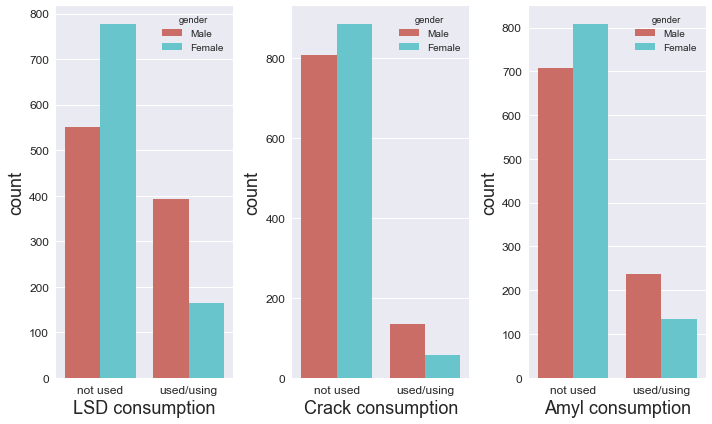

In [145]:
#  Bar graph for drug consumption count by gender

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3)
g1 = sns.countplot(x=statistical_data['lsd_consp_decade'],hue = statistical_data['gender'], 
                   palette = "hls", ax=ax1)
g2 = sns.countplot(x= statistical_data['crack_consp_decade'],hue = statistical_data['gender'],
                   palette = "hls", ax=ax2)
g3 = sns.countplot(x= statistical_data['amly_consp_decade'],hue = statistical_data['gender'],
                   palette = "hls", ax=ax3)

g1.set_ylabel("count", fontsize = 18)
g1.set_xlabel('LSD consumption', fontsize = 18)
g1.tick_params(labelsize=12)
g2.set_ylabel("count", fontsize = 18)
g2.set_xlabel('Crack consumption', fontsize = 18)
g2.tick_params(labelsize=12)
g3.set_ylabel("count", fontsize = 18)
g3.set_xlabel('Amyl consumption', fontsize = 18)
g3.tick_params(labelsize=12)

plt.gcf().set_size_inches(10,6)
plt.tight_layout()
plt.savefig("../images/drugconsp_bygender.png");

## Models Analyzed

In the following, 8 models were investigated to determine the best model for drug usage prediction.

### A : LogisticRegression(penalty = $'l_{1}'$) with personality traits data

Since the categorical variable drug consumption ("used/using" = class 1) and ("not used" = class 0) is imbalanced, I will use one of the oversampling method to deal with this problem and I will look at recall metric and confusion matrix to evaluate the model performance [**](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

The hyperparameter `C` for logistic regression searched over a range using sklearn `GridSearchCV` method for the specific drug consumption. After defining optimum `C`, logistic regression fit on the oversampled training data to train the model. Finally, recall results from the test data was calculated to compare the models performance.

In [194]:
# Logistic regression with 'L1' penalty + Oversampling on drug_traits data 

X = drug_traits
# drug analyzed
y = drug_data.loc[:,["lsd_consp_decade", "crack_consp_decade", "amly_consp_decade"]]

for i in [0, 1, 2]:
    X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,i], test_size = 0.2, random_state = 233)
    # oversampling
    sm = SMOTE(random_state=12, ratio = 1.0)
    x_res, y_res = sm.fit_sample(X_train, y_train)
    #print(y_train.value_counts(), np.bincount(y_res))

    param_grid = {"C" : 10.0**np.arange(-3,3)}
    grid = GridSearchCV(LogisticRegression(penalty = 'l1'), param_grid = param_grid, scoring = 'recall', cv =10)
    grid.fit(x_res, y_res)
    
    print("best param C: {}".format(grid.best_params_['C']))
    print("best score: {}".format(grid.best_score_))
    logit = LogisticRegression(penalty = 'l1', C = grid.best_params_['C'])
    logit.fit(x_res, y_res)
    
    L1_selec_feat = np.where(np.absolute(logit.coef_/np.max(logit.coef_))> 10**-6)
    print("\nNumber of features chosen by 'L1' regularization: {}".format(len(L1_selec_feat[0])))
    print("Features chosen by L1 regularization:\n{}".format(X.columns[L1_selec_feat[1]]))

    print("Method: Logistic Regression (l1)")
    #print("X_test.shape {}".format(X_test.shape))
    #print("x_res.shape {}".format(x_res.shape))
    print("{}".format(y.columns[i]))
    #print("training accuracy with oversampled data is {:.3f}".format(logit.score(x_res, y_res)))
    print("test data recall with oversampled data is {:.3f}".format(recall_score(y_test, logit.predict(X_test))))
    print("test data accuracy is {:.3f}".format(logit.score(X_test, y_test)))
    print("Classification report:\n {}".format(classification_report(y_test,logit.predict(X_test), 
                                        target_names = ['not used', 'used'])))
    print("Confussion matrix: \n {}".format(confusion_matrix(y_test, logit.predict(X_test))))
    
    print("--------------------------------")
    print("================================================")



C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


best param C: 100.0
best score: 0.8163074039362699

Number of features chosen by 'L1' regularization: 12
Features chosen by L1 regularization:
Index(['age', 'gender', 'education', 'country', 'ethnicity', 'neuroticism',
       'extraversion', 'openness', 'agreeableness', 'conscient', 'impulsuv',
       'SS'],
      dtype='object')
Method: Logistic Regression (l1)
lsd_consp_decade
test data recall with oversampled data is 0.784
test data accuracy is 0.764
Classification report:
              precision    recall  f1-score   support

   not used       0.89      0.75      0.82       261
       used       0.59      0.78      0.67       116

avg / total       0.79      0.76      0.77       377

Confussion matrix: 
 [[197  64]
 [ 25  91]]
--------------------------------


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


best param C: 0.01
best score: 0.8207964601769911

Number of features chosen by 'L1' regularization: 6
Features chosen by L1 regularization:
Index(['gender', 'education', 'country', 'agreeableness', 'impulsuv', 'SS'], dtype='object')
Method: Logistic Regression (l1)
crack_consp_decade
test data recall with oversampled data is 0.744
test data accuracy is 0.658
Classification report:
              precision    recall  f1-score   support

   not used       0.96      0.65      0.77       338
       used       0.20      0.74      0.31        39

avg / total       0.88      0.66      0.72       377

Confussion matrix: 
 [[219 119]
 [ 10  29]]
--------------------------------


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


best param C: 0.01
best score: 0.7713338856669428

Number of features chosen by 'L1' regularization: 4
Features chosen by L1 regularization:
Index(['age', 'gender', 'country', 'SS'], dtype='object')
Method: Logistic Regression (l1)
amly_consp_decade
test data recall with oversampled data is 0.768
test data accuracy is 0.560
Classification report:
              precision    recall  f1-score   support

   not used       0.91      0.51      0.66       308
       used       0.26      0.77      0.39        69

avg / total       0.79      0.56      0.61       377

Confussion matrix: 
 [[158 150]
 [ 16  53]]
--------------------------------


### B : KNN algorithm with personality traits data
Same procedures as in A part are followed expect KNN algorithm is used.

In [193]:
# KNN algorithm + Oversampling on drug_traits data

X = drug_traits
y = drug_data.loc[:,["lsd_consp_decade", "crack_consp_decade", "amly_consp_decade"]]

for i in [0, 1, 2]:
    X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,i], test_size = 0.2, random_state = 233)
    # oversampling
    sm = SMOTE(random_state=12, ratio = 1.0)
    x_res, y_res = sm.fit_sample(X_train, y_train)

    param_grid = {"n_neighbors" : np.arange(10, 80, 2)}
    grid = GridSearchCV(KNeighborsClassifier(),param_grid = param_grid, scoring = 'recall', cv =10)
    grid.fit(x_res, y_res)

    print("best param n_neighbors: {}".format(grid.best_params_['n_neighbors']))
    print("best score: {}".format(grid.best_score_))
    knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
    knn.fit(x_res, y_res)
 
    print("method : Kneighbors")
    print("{}".format(y.columns[i]))
    # print("X_test.shape {}".format(X_test.shape))
    # print("x_res.shape {}".format(x_res.shape))
    print("test data recall is {:.3f}".format(recall_score(y_test, knn.predict(X_test))))
    print("Classification report:\n {}".format(classification_report(y_test,knn.predict(X_test), 
                                        target_names = ['not used', 'used'])))
    print("Confussion matrix: \n {}".format(confusion_matrix(y_test, knn.predict(X_test))))

    print("--------------------------------")
    print("================================================")




C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


best param n_neighbors: 10
best score: 0.8819119025304593
method : Kneighbors
lsd_consp_decade
test data recall is 0.793
Classification report:
              precision    recall  f1-score   support

   not used       0.89      0.74      0.81       261
       used       0.58      0.79      0.67       116

avg / total       0.79      0.76      0.77       377

Confussion matrix: 
 [[194  67]
 [ 24  92]]
--------------------------------


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


best param n_neighbors: 10
best score: 0.9852507374631269
method : Kneighbors
crack_consp_decade
test data recall is 0.590
Classification report:
              precision    recall  f1-score   support

   not used       0.93      0.66      0.77       338
       used       0.17      0.59      0.26        39

avg / total       0.85      0.65      0.72       377

Confussion matrix: 
 [[223 115]
 [ 16  23]]
--------------------------------


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


best param n_neighbors: 10
best score: 0.9395194697597349
method : Kneighbors
amly_consp_decade
test data recall is 0.551
Classification report:
              precision    recall  f1-score   support

   not used       0.86      0.62      0.72       308
       used       0.24      0.55      0.34        69

avg / total       0.75      0.60      0.65       377

Confussion matrix: 
 [[190 118]
 [ 31  38]]
--------------------------------


### C: Random Forest with personality traits data

Other than logistic regression and KNN, I also tried Random Forest however random forest was not a good model for this classification task.

In [6]:
# Random Forest on drug_traits data
# Over sampling is done before RFE

drug_traits = drug_data.loc[:,['age', "gender", "education", "country",
"ethnicity","neuroticism", "extraversion", 
"openness", "agreeableness", "conscient", "impulsuv",
"SS"]]
drug_traits_copy = drug_traits.copy()

X = drug_traits_copy.values
y = drug_data.loc[:,["lsd_consp_decade", "crack_consp_decade", "amly_consp_decade"]]

for j in [0, 1, 2]:

    X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,j], test_size = 0.2, random_state = 22345)

    sm = SMOTE(random_state=12, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    no_feature = np.arange(1, 10, 1)
    recall_scores = []
    selected_features = []
    best_params = []
    for i in no_feature:
        rfe = RFE(estimator = LogisticRegression(), n_features_to_select = i)
        rfe.fit(X_train_res, y_train_res)
        X_train_sel = X_train_res[:, rfe.support_]
        X_test_sel = X_test[:, rfe.support_]
        selected_features.append(rfe.support_)
    
        param_grid = {"n_estimators" : np.arange(10, 100, 5)}
        grid = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, scoring = 'recall', cv =10)
        grid.fit(X_train_sel, y_train_res)
        rforest = RandomForestClassifier(n_estimators = grid.best_params_['n_estimators'])
        rforest.fit(X_train_sel, y_train_res)
        best_params.append(grid.best_params_['n_estimators'])
        recall_scores.append(recall_score(y_test, rforest.predict(X_test_sel)))
        
    opt_selected_features = selected_features[np.argmax(recall_scores)]
    opt_n = best_params[np.argmax(recall_scores)]

    print(y.columns[j])
    print("Optimum number of features is {}".format(no_feature[np.argmax(recall_scores)]))
    print(selected_features[np.argmax(recall_scores)])
    print("name of selected_features {}".format(drug_traits_copy.columns[opt_selected_features]))
    #print(recall_scores)
    #plt.plot(no_feature, recall_scores,"-o", color = 'red');

    X_test_sel = X_test[:, opt_selected_features]
    rforest = RandomForestClassifier(n_estimators= opt_n)
    rforest.fit(X_train_res, y_train_res)
    print()
    print("training recall is {:.3f}".format(recall_score(y_train_res, rforest.predict(X_train_res))))
    print("test recall is {:.3f}".format(recall_score(y_test, rforest.predict(X_test))))
    print("Classification report:\n {}".format(classification_report(y_test,rforest.predict(X_test), 
                                        target_names = ['not used', 'used'])))
    print("Confussion matrix: \n {}".format(confusion_matrix(y_test, rforest.predict(X_test))))



C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


lsd_consp_decade
Optimum number of features is 1
[False False False  True False False False False False False False False]
name of selected_features Index(['country'], dtype='object')

training recall is 0.986
test recall is 0.571
Classification report:
              precision    recall  f1-score   support

   not used       0.82      0.85      0.83       265
       used       0.61      0.57      0.59       112

avg / total       0.76      0.76      0.76       377

Confussion matrix: 
 [[224  41]
 [ 48  64]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


crack_consp_decade
Optimum number of features is 1
[False False False  True False False False False False False False False]
name of selected_features Index(['country'], dtype='object')

training recall is 0.995
test recall is 0.150
Classification report:
              precision    recall  f1-score   support

   not used       0.90      0.95      0.92       337
       used       0.25      0.15      0.19        40

avg / total       0.83      0.86      0.85       377

Confussion matrix: 
 [[319  18]
 [ 34   6]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


amly_consp_decade
Optimum number of features is 1
[False  True False False False False False False False False False False]
name of selected_features Index(['gender'], dtype='object')

training recall is 0.993
test recall is 0.257
Classification report:
              precision    recall  f1-score   support

   not used       0.84      0.89      0.86       307
       used       0.35      0.26      0.30        70

avg / total       0.75      0.77      0.76       377

Confussion matrix: 
 [[273  34]
 [ 52  18]]


### D: RFE() and Logistic Regression(penalty = $'l_{2}'$) with personality traits data

The recall rates from part A and B appear to be improved. Both KNN and logistic regression with $l_{1}$ regularization gave very similar results. Therefore, in this part I used `RFE()` method to select relevant features and also logistic regression with $'l_{2}$' regularization. The findings are still very similar to in part A and B however, due to feature selection we can talk about important features as in part A $'l_{1}$' regularization also acts as feature selection method. For each drug consumption different features are selected but mainly `gender`, `country` and `age` are the most important features to explain the data. 

In [15]:
# RFE + Logistic Regression. Over sampling is done before RFE

drug_traits = drug_data.loc[:,['age', "gender", "education", "country",
"ethnicity","neuroticism", "extraversion", 
"openness", "agreeableness", "conscient", "impulsuv",
"SS"]]
drug_traits_copy = drug_traits.copy()

X = drug_traits_copy.values
y = drug_data.loc[:,["lsd_consp_decade", "crack_consp_decade", "amly_consp_decade"]]

for j in [0, 1, 2]:

    X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,j], test_size = 0.2, random_state = 22345)

    sm = SMOTE(random_state=12, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    no_feature = np.arange(1, 10, 1)
    recall_scores = []
    selected_features = []
    best_params = []
    for i in no_feature:
        rfe = RFE(estimator = LogisticRegression(), n_features_to_select = i)
        rfe.fit(X_train_res, y_train_res)
        X_train_sel = X_train_res[:, rfe.support_]
        X_test_sel = X_test[:, rfe.support_]
        selected_features.append(rfe.support_)
    
        param_grid = {"C" : 10.0**np.arange(-3,3)}
        grid = GridSearchCV(LogisticRegression(), param_grid = param_grid, scoring = 'recall', cv =10)
        grid.fit(X_train_sel, y_train_res)
        logit = LogisticRegression(C = grid.best_params_['C'])
        logit.fit(X_train_sel, y_train_res)
        best_params.append(grid.best_params_['C'])
        recall_scores.append(recall_score(y_test, logit.predict(X_test_sel)))
        
    opt_selected_features = selected_features[np.argmax(recall_scores)]
    opt_c = best_params[np.argmax(recall_scores)]
    
    
    print("Method: RFE + Logistic Regression l2")
    print(y.columns[j])
    print("Optimum number of features is {}".format(no_feature[np.argmax(recall_scores)]))
    print(selected_features[np.argmax(recall_scores)])
    print("name of selected_features {}".format(drug_traits_copy.columns[opt_selected_features]))
    #print(recall_scores)
    #plt.plot(no_feature, recall_scores,"-o", color = 'red');

    X_test_sel = X_test[:, opt_selected_features]
    logit = LogisticRegression(C = opt_c)
    logit.fit(X_train_res, y_train_res)
    print()
    #print("training recall is {:.3f}".format(recall_score(y_train_res, logit.predict(X_train_res))))
    print("test recall is {:.3f}".format(recall_score(y_test, logit.predict(X_test))))
    print("Classification report:\n {}".format(classification_report(y_test,logit.predict(X_test), 
                                        target_names = ['not used', 'used'])))
    print("Confussion matrix: \n {}".format(confusion_matrix(y_test, logit.predict(X_test))))



C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Method: RFE + Logistic Regression l2
lsd_consp_decade
Optimum number of features is 7
[ True  True False  True  True False  True  True False False False  True]
name of selected_features Index(['age', 'gender', 'country', 'ethnicity', 'extraversion', 'openness',
       'SS'],
      dtype='object')

training recall is 0.832
test recall is 0.786
Classification report:
              precision    recall  f1-score   support

   not used       0.89      0.76      0.82       265
       used       0.58      0.79      0.67       112

avg / total       0.80      0.77      0.77       377

Confussion matrix: 
 [[201  64]
 [ 24  88]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Method: RFE + Logistic Regression l2
crack_consp_decade
Optimum number of features is 6
[ True  True  True  True False False False False False False  True  True]
name of selected_features Index(['age', 'gender', 'education', 'country', 'impulsuv', 'SS'], dtype='object')

training recall is 0.800
test recall is 0.700
Classification report:
              precision    recall  f1-score   support

   not used       0.94      0.59      0.73       337
       used       0.17      0.70      0.27        40

avg / total       0.86      0.60      0.68       377

Confussion matrix: 
 [[200 137]
 [ 12  28]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Method: RFE + Logistic Regression l2
amly_consp_decade
Optimum number of features is 1
[False  True False False False False False False False False False False]
name of selected_features Index(['gender'], dtype='object')

training recall is 0.734
test recall is 0.643
Classification report:
              precision    recall  f1-score   support

   not used       0.89      0.64      0.75       307
       used       0.29      0.64      0.40        70

avg / total       0.78      0.64      0.68       377

Confussion matrix: 
 [[198 109]
 [ 25  45]]


### E: RFE() and KNN algorithm with personality traits data

KNN algorithm performed comparable to logistic regression I also want to use it after feature selection. Feature selection did not help improve the model performance. 

In [22]:
# KNN + RFE. Over sampling is done before RFE

drug_traits = drug_data.loc[:,['age', "gender", "education", "country",
"ethnicity","neuroticism", "extraversion", 
"openness", "agreeableness", "conscient", "impulsuv",
"SS"]]
drug_traits_copy = drug_traits.copy()

X = drug_traits_copy.values
y = drug_data.loc[:,["lsd_consp_decade", "crack_consp_decade", "amly_consp_decade"]]

for j in [0, 1, 2]:

    X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,j], test_size = 0.2, random_state = 22345)

    sm = SMOTE(random_state=12, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    no_feature = np.arange(1, 10, 1)
    recall_scores = []
    selected_features = []
    best_params = []
    for i in no_feature:
        rfe = RFE(estimator = LogisticRegression(), n_features_to_select = i)
        rfe.fit(X_train_res, y_train_res)
        X_train_sel = X_train_res[:, rfe.support_]
        X_test_sel = X_test[:, rfe.support_]
        selected_features.append(rfe.support_)
    
        param_grid = {"n_neighbors" : np.arange(4,20,2)}
        grid = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, scoring = 'recall', cv =10)
        grid.fit(X_train_sel, y_train_res)
        knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
        knn.fit(X_train_sel, y_train_res)
        best_params.append(grid.best_params_['n_neighbors'])
        recall_scores.append(recall_score(y_test, knn.predict(X_test_sel)))
        
    opt_selected_features = selected_features[np.argmax(recall_scores)]
    opt_neighbors = best_params[np.argmax(recall_scores)]

    print("Method: RFE + KNN")
    print(y.columns[j])
    print("Optimum number of features is {}".format(no_feature[np.argmax(recall_scores)]))
    print(selected_features[np.argmax(recall_scores)])
    print("name of selected_features {}".format(drug_traits_copy.columns[opt_selected_features]))
    
    X_test_sel = X_test[:, opt_selected_features]
    knn = KNeighborsClassifier(n_neighbors = opt_neighbors)
    knn.fit(X_train_res, y_train_res)
    
    print("test recall is {:.3f}".format(recall_score(y_test, knn.predict(X_test))))
    print("Classification report:\n {}".format(classification_report(y_test,knn.predict(X_test), 
                                        target_names = ['not used', 'used'])))
    print("Confussion matrix: \n {}".format(confusion_matrix(y_test, knn.predict(X_test))))



C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Method: RFE + KNN
lsd_consp_decade
Optimum number of features is 7
[ True  True False  True  True False  True  True False False False  True]
name of selected_features Index(['age', 'gender', 'country', 'ethnicity', 'extraversion', 'openness',
       'SS'],
      dtype='object')
test recall is 0.848
Classification report:
              precision    recall  f1-score   support

   not used       0.92      0.71      0.80       265
       used       0.55      0.85      0.67       112

avg / total       0.81      0.75      0.76       377

Confussion matrix: 
 [[187  78]
 [ 17  95]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Method: RFE + KNN
crack_consp_decade
Optimum number of features is 7
[ True  True  True  True False  True False False False False  True  True]
name of selected_features Index(['age', 'gender', 'education', 'country', 'neuroticism', 'impulsuv',
       'SS'],
      dtype='object')
test recall is 0.575
Classification report:
              precision    recall  f1-score   support

   not used       0.93      0.66      0.77       337
       used       0.17      0.57      0.26        40

avg / total       0.85      0.65      0.72       377

Confussion matrix: 
 [[223 114]
 [ 17  23]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Method: RFE + KNN
amly_consp_decade
Optimum number of features is 6
[ True  True False  True  True False False False False  True False  True]
name of selected_features Index(['age', 'gender', 'country', 'ethnicity', 'conscient', 'SS'], dtype='object')
test recall is 0.629
Classification report:
              precision    recall  f1-score   support

   not used       0.87      0.59      0.70       307
       used       0.26      0.63      0.37        70

avg / total       0.76      0.59      0.64       377

Confussion matrix: 
 [[180 127]
 [ 26  44]]


### F: RFE() and Logistic Regression(penalty = $'l_{2}'$) with personality traits + drug consumption data

In this part and in the subsequent parts, I included drug consumption information as an explanatory variables along with demographic and personality trait variables. 

The recall was very high 0.96 for LSD user, 0.85 for crack user and 0.84 for amyl nitrite user. This findings tells us that if we have the information regarding other drug consumptions, we can predict whether the drug user is "used" or "using" the particular drug.  

In [208]:
# Other Drugs' Consumptions Added as explanatory variables
# RFE + Logistic Regression(l2)

# Over sampling is done before RFE

drug_copy = drug_data.copy()

X = drug_copy
drug_analyzed = ["lsd_consp_decade", "crack_consp_decade", "amly_consp_decade"]

    
y = drug_data.loc[:,drug_analyzed]

for j in [0, 1, 2]:
    
    X_dropped = X.drop(str(drug_analyzed[j]), axis = 1).values
    X_train, X_test, y_train, y_test = train_test_split(X_dropped, y.iloc[:,j], test_size = 0.2, random_state = 22345)

    sm = SMOTE(random_state=12, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    no_feature = np.arange(1, 10, 1)
    recall_scores = []
    selected_features = []
    best_params = []
    for i in no_feature:
        rfe = RFE(estimator = LogisticRegression(), n_features_to_select = i)
        rfe.fit(X_train_res, y_train_res)
        X_train_sel = X_train_res[:, rfe.support_]
        X_test_sel = X_test[:, rfe.support_]
        selected_features.append(rfe.support_)
        param_grid = {"C" : 10.0**np.arange(-3,3)}
        grid = GridSearchCV(LogisticRegression(), param_grid = param_grid, scoring = 'recall', cv =10)
        grid.fit(X_train_sel, y_train_res)
        logit = LogisticRegression(C = grid.best_params_['C'])
        logit.fit(X_train_sel, y_train_res)
        best_params.append(grid.best_params_['C'])
        recall_scores.append(recall_score(y_test, logit.predict(X_test_sel)))
    opt_selected_features = selected_features[np.argmax(recall_scores)]
    opt_c = best_params[np.argmax(recall_scores)]

    print(y.columns[j])
    print("Optimum number of features is {}".format(no_feature[np.argmax(recall_scores)]))
    print(selected_features[np.argmax(recall_scores)])
    print("name of selected_features {}".format(drug_copy.columns[opt_selected_features]))
    #print(recall_scores)
    #plt.plot(no_feature, recall_scores,"-o", color = 'red');

    X_test_sel = X_test[:, opt_selected_features]
    logit = LogisticRegression(C = opt_c)
    logit.fit(X_train_res, y_train_res)
    #print("training recall is {:.3f}".format(recall_score(y_train_res, logit.predict(X_train_res))))
    print("test recall is {:.3f}".format(recall_score(y_test, logit.predict(X_test))))
    print("Classification report:\n {}".format(classification_report(y_test,logit.predict(X_test), 
                                        target_names = ['not used', 'used'])))
    print("Confussion matrix: \n {}".format(confusion_matrix(y_test, logit.predict(X_test))))





C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


lsd_consp_decade
Optimum number of features is 4
[False False False  True False False False False False False False False
 False False False False False False False False False  True False  True
 False False  True False False False]
name of selected_features Index(['country', 'ecstasy_consp_decade', 'ketamine_consp_decade',
       'meth_consp_decade'],
      dtype='object')
test recall is 0.955
Classification report:
              precision    recall  f1-score   support

   not used       0.97      0.73      0.84       265
       used       0.60      0.96      0.74       112

avg / total       0.86      0.80      0.81       377

Confussion matrix: 
 [[194  71]
 [  5 107]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 30
  result = getitem(key)
C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


crack_consp_decade
Optimum number of features is 1
[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False]
name of selected_features Index(['cocaine_consp_decade'], dtype='object')
test recall is 0.850
Classification report:
              precision    recall  f1-score   support

   not used       0.97      0.66      0.79       337
       used       0.23      0.85      0.36        40

avg / total       0.89      0.68      0.74       377

Confussion matrix: 
 [[223 114]
 [  6  34]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 30
  result = getitem(key)
C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


amly_consp_decade
Optimum number of features is 4
[False False False  True False False False False False False False False
 False  True False False  True False False False  True False False False
 False False False False False False]
name of selected_features Index(['country', 'amphet_consp_decade', 'caff_consp_decade',
       'crack_consp_decade'],
      dtype='object')
test recall is 0.829
Classification report:
              precision    recall  f1-score   support

   not used       0.94      0.59      0.72       307
       used       0.32      0.83      0.46        70

avg / total       0.82      0.63      0.67       377

Confussion matrix: 
 [[181 126]
 [ 12  58]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 30
  result = getitem(key)


### G: RFE() and Logistic Regression(penalty = $'l_{1}'$) with personality traits + drug consumption data

The recall rates for non drug user was comparably lower than the recall rates for drug users in part F with $'l_{2}'$ regularization. However, the recall rates for both drug user and non user are relatively similar in this part. The recalls for LSD, crack and amly nitrite "user" are 0.93, 0.85 and 0.74, respectively. The recalls for LSD, crack and amly nitrite "non user" are 0.84, 0.80 and 0.73, respectively. 

In [17]:
# Other Drugs' Consumptions Added as explanatory variables
# RFE + Logistic Regression(l1)

# Over sampling is done before RFE

drug_copy = drug_data.copy()

X = drug_copy
drug_analyzed = ["lsd_consp_decade", "crack_consp_decade", "amly_consp_decade"]

    
y = drug_data.loc[:,drug_analyzed]

for j in [0, 1, 2]:
    
    X_dropped = X.drop(str(drug_analyzed[j]), axis = 1).values
    X_train, X_test, y_train, y_test = train_test_split(X_dropped, y.iloc[:,j], test_size = 0.2, random_state = 22345)

    sm = SMOTE(random_state=12, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    no_feature = np.arange(1, 10, 1)
    recall_scores = []
    selected_features = []
    best_params = []
    for i in no_feature:
        rfe = RFE(estimator = LogisticRegression(), n_features_to_select = i)
        rfe.fit(X_train_res, y_train_res)
        X_train_sel = X_train_res[:, rfe.support_]
        X_test_sel = X_test[:, rfe.support_]
        selected_features.append(rfe.support_)
    
        param_grid = {"C" : 10.0**np.arange(-3,3)}
        grid = GridSearchCV(LogisticRegression(penalty = 'l1'), param_grid = param_grid, 
                            scoring = 'recall', cv =10)
        grid.fit(X_train_sel, y_train_res)
        logit = LogisticRegression(C = grid.best_params_['C'])
        logit.fit(X_train_sel, y_train_res)
        best_params.append(grid.best_params_['C'])
        recall_scores.append(recall_score(y_test, logit.predict(X_test_sel)))
        
    opt_selected_features = selected_features[np.argmax(recall_scores)]
    opt_c = best_params[np.argmax(recall_scores)]

    print(y.columns[j])
    print("Optimum number of features is {}".format(no_feature[np.argmax(recall_scores)]))
    print(selected_features[np.argmax(recall_scores)])
    print("name of selected_features {}".format(drug_copy.columns[opt_selected_features]))
    #print(recall_scores)
    #plt.plot(no_feature, recall_scores,"-o", color = 'red');

    X_test_sel = X_test[:, opt_selected_features]
    logit = LogisticRegression(C = opt_c)
    logit.fit(X_train_res, y_train_res)
    print()
    #print("training recall is {:.3f}".format(recall_score(y_train_res, logit.predict(X_train_res))))
    print("test recall is {:.3f}".format(recall_score(y_test, logit.predict(X_test))))
    print("Classification report:\n {}".format(classification_report(y_test,logit.predict(X_test), 
                                        target_names = ['not used', 'used'])))
    print("Confussion matrix: \n {}".format(confusion_matrix(y_test, logit.predict(X_test))))





C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


lsd_consp_decade
Optimum number of features is 2
[False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False  True False False False]
name of selected_features Index(['ecstasy_consp_decade', 'meth_consp_decade'], dtype='object')

test recall is 0.929
Classification report:
              precision    recall  f1-score   support

   not used       0.97      0.84      0.90       265
       used       0.71      0.93      0.81       112

avg / total       0.89      0.87      0.87       377

Confussion matrix: 
 [[223  42]
 [  8 104]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 30
  result = getitem(key)
C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


crack_consp_decade
Optimum number of features is 1
[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False]
name of selected_features Index(['cocaine_consp_decade'], dtype='object')

test recall is 0.850
Classification report:
              precision    recall  f1-score   support

   not used       0.98      0.80      0.88       337
       used       0.34      0.85      0.48        40

avg / total       0.91      0.81      0.84       377

Confussion matrix: 
 [[270  67]
 [  6  34]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 30
  result = getitem(key)
C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


amly_consp_decade
Optimum number of features is 1
[False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False]
name of selected_features Index(['caff_consp_decade'], dtype='object')

test recall is 0.743
Classification report:
              precision    recall  f1-score   support

   not used       0.93      0.73      0.82       307
       used       0.39      0.74      0.51        70

avg / total       0.83      0.73      0.76       377

Confussion matrix: 
 [[225  82]
 [ 18  52]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 30
  result = getitem(key)


### H: RFE() and KNN with with personality traits + drug consumption data

Recall rates for drug users with KNN are also acceptable however recall rates for non drug users are in the low side.

In [24]:
# KNN + RFE + Other Drug Consumptions

# Other Drugs' Consumptions Added as explanatory variables

drug_copy = drug_data.copy()

X = drug_copy
drug_analyzed = ["lsd_consp_decade", "crack_consp_decade", "amly_consp_decade"]

    
y = drug_data.loc[:,drug_analyzed]

for j in [0, 1, 2]:
    
    X_dropped = X.drop(str(drug_analyzed[j]), axis = 1).values
    X_train, X_test, y_train, y_test = train_test_split(X_dropped, y.iloc[:,j], test_size = 0.2, random_state = 22345)

    sm = SMOTE(random_state=12, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

    no_feature = np.arange(1, 10, 1)
    recall_scores = []
    selected_features = []
    best_params = []
    for i in no_feature:
        rfe = RFE(estimator = LogisticRegression(), n_features_to_select = i)
        rfe.fit(X_train_res, y_train_res)
        X_train_sel = X_train_res[:, rfe.support_]
        X_test_sel = X_test[:, rfe.support_]
        selected_features.append(rfe.support_)
    
        param_grid = {"n_neighbors" : np.arange(2,20,2)}
        grid = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, scoring = 'recall', cv =10)
        grid.fit(X_train_sel, y_train_res)
        knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
        knn.fit(X_train_sel, y_train_res)
        best_params.append(grid.best_params_['n_neighbors'])
        recall_scores.append(recall_score(y_test, knn.predict(X_test_sel)))
        
    opt_selected_features = selected_features[np.argmax(recall_scores)]
    opt_neighbors = best_params[np.argmax(recall_scores)]

    print(y.columns[j])
    print("Optimum number of features is {}".format(no_feature[np.argmax(recall_scores)]))
    print(selected_features[np.argmax(recall_scores)])
    print("name of selected_features {}".format(drug_copy.columns[opt_selected_features]))
    
    X_test_sel = X_test[:, opt_selected_features]
    knn = KNeighborsClassifier(n_neighbors = opt_neighbors)
    knn.fit(X_train_res, y_train_res)

    print("test recall is {:.3f}".format(recall_score(y_test, knn.predict(X_test))))
    print("Classification report:\n {}".format(classification_report(y_test,knn.predict(X_test), 
                                        target_names = ['not used', 'used'])))
    print("Confussion matrix: \n {}".format(confusion_matrix(y_test, knn.predict(X_test))))





C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


lsd_consp_decade
Optimum number of features is 5
[False False False  True False False False False False False False False
 False False False False  True False False False False  True False  True
 False False  True False False False]
name of selected_features Index(['country', 'caff_consp_decade', 'ecstasy_consp_decade',
       'ketamine_consp_decade', 'meth_consp_decade'],
      dtype='object')
test recall is 0.946
Classification report:
              precision    recall  f1-score   support

   not used       0.97      0.77      0.86       265
       used       0.63      0.95      0.76       112

avg / total       0.87      0.82      0.83       377



C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 30
  result = getitem(key)


Confussion matrix: 
 [[203  62]
 [  6 106]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


crack_consp_decade
Optimum number of features is 4
[False False False False False False False False False False False False
  True False False False False  True False  True False  True False False
 False False False False False False]
name of selected_features Index(['alco_consp_decade', 'cannabis_consp_decade', 'cocaine_consp_decade',
       'ecstasy_consp_decade'],
      dtype='object')
test recall is 0.775
Classification report:
              precision    recall  f1-score   support

   not used       0.96      0.74      0.84       337
       used       0.26      0.78      0.39        40

avg / total       0.89      0.74      0.79       377



C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 30
  result = getitem(key)


Confussion matrix: 
 [[248  89]
 [  9  31]]


C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


amly_consp_decade
Optimum number of features is 2
[False False False False False False False False False False False False
 False False False False  True False False False  True False False False
 False False False False False False]
name of selected_features Index(['caff_consp_decade', 'crack_consp_decade'], dtype='object')
test recall is 0.843
Classification report:
              precision    recall  f1-score   support

   not used       0.95      0.64      0.76       307
       used       0.35      0.84      0.49        70

avg / total       0.83      0.67      0.71       377



C:\Users\BeyzaZehra\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 31 but corresponding boolean dimension is 30
  result = getitem(key)


Confussion matrix: 
 [[195 112]
 [ 11  59]]
